# Catboost

# Деревья в catboost

В catboost деревья строятся особым образом. Во-первых, они симметричные, во-вторых, на каждом уровне дерева для разделения вершины на листья используются одни и те же пороги и признаки. То есть для корневого узла один признак и порог, для его листьев один и тот же признак и порог и т.д. 

На каждой итерации catboost дерево строится так:

- Во внешнем цикле проходимся по каждому уровню дерева, начиная с корня, пока не достигнем максимальной глубины дерева.

- Во внутреннем цикле перебираем всевозможные признаки и пороги для разделения, пробуем делать разделение на листья для каждой вершины в соответствующем уровне дерева (для каждой вершины разделение делается по одному и тому же порогу и признаку).

- Смотрим, в какой лист попадает каждый объект в обучающей выборке. Для каждого объекта в выборке считаем выходное значение в листе с учетом того, в какой лист попадает данный объект.

- В итоге получаем предсказанный вектор градиентов и реальные градиенты. Считаем косинус между этими векторами. Это будет наш score. Для каждого возможного разделения в соответствующем уровне дерева считаем свой score. На каждом уровне дерева выбирается разделение с наибольшим score (это значит векторы наиболее похожи).

В результате мы получаем более слабое дерево (слабая модель), чем обычное дерево решений, которое меньше переобучается и более устойчиво к изменениям гиперпараметров модели. 

# Разделение 

Разделение происходит по специальному критерию, который работает так, чтобы как можно лучше приближать вектор градиентов. Сравнивается то, насколько вектор значений в листьях похож на вектор градиентов с помощью косинусного расстояния. Выбирается тот признак и порог для разделения, для которых данный критерий дает максимальное значение.

При каждом разделении считается критерий и к нему добавляется некая случайная величина (случайность) для снижения переобучения:

$score$ += $random\_strength \cdot N, N - $нормальное распределение с нулевым средним


# Бутстрэп

В catboost используются не все данные для обучения или объекты могут браться с определенным весом. Эти веса, например, используются для вычисления значении [функции потерь или метрик](https://catboost.ai/en/docs/concepts/loss-functions-regression)

Способ Бернулли: $w$ = 0 или 1 

Способ Байесовский: $w$ $*= (-log(rand(0,1)))^{bagging\_temperature}$

# Работа с категориальными признаками

1.$One$-$hot$ $encoding$, если категорий в признаке немного (2 по умолчанию)

2.$Ordered$ $mean$ $target$ $encoding$. Хотим или нет, но использование таргета при кодировке признаков приводит к переобучению, но в catboost попытались минимизировать это переобучение. При использовании других способов target encoding можно придумать такую выборку, что мы переобучимся под нее, например, если в выборке есть категориальный признак, в котором есть категория, которая встречается только один раз, то в случае использования mean target encoding мы закодируем эту категорию значением таргета, что приводит к переобучению. В catboost используется ordered mean target encoding. На каждой итерации построения дерева происходит случайная перестановка строк в датасете. Далее считаем статистику по прошлому, то есть среднее значение таргета для i-ой строки, вычисленное по предыдущим строкам в датасете (которые стоят выше). Для этого способа тоже можно придумать "плохую" выборку (пример с таблицей ниже), но для решения этой проблемы перед построением каждого дерева мы делаем перестановку, а так как данный способ кодировки учитывает порядок строк в датасете, новые значения категориального признака часто будут разными для каждого дерева. Это приводит к снижению переобучения. В качестве значении для кодирования категориальных признаков в новых данных используется обычный mean target encoding по тренировочному датасету.

$CTR = \frac{pos+prior}{all+1}$

$pos$ - количество 1 в таргете для данного класса, которое встретилось до текущей строки

$all$ - количество наблюдений данного класса, которое встретилось до текущей строки

$prior$ - небольшое число

Пример: $prior$ = 0.1
 
| id | Питомец | Метка | Перестановка | id | Питомец | Метка | Кодировка |
|:--:|:-------:|:-----:|:------------:|:--:|:-------:|:-----:|:---------:|
|  1 |  Котик  |   0   |      =>      |  5 |  Хомяк  |   1   |    0.1    |
|  2 |  Песик  |   1   |      =>      |  3 |  Котик  |   1   |    0.1    |
|  3 |  Котик  |   1   |      =>      |  4 |  Хомяк  |   0   |    0.55   |
|  4 |  Хомяк  |   0   |      =>      |  1 |  Котик  |   0   |    0.55   |
|  5 |  Хомяк  |   1   |      =>      |  2 |  Песик  |   1   |    0.1    |


3.$Комбинации$ $признаков$. Во время предобработки не получится построить все комбинации категориальных признаков, так как количество комбинации растет экспоненциально. Вместо этого в catboost комбинации строятся не перед началом обучения, а жадным алгоритмом при построении каждого дерева. 

Пример: 

Пусть $x1, x2, x3, x4$ - категориальные признаки. Если на некотором уровне дерева в качестве разделения был выбран категориальный признак $x1$, то на следующем уровне дерева будут перебираться признаки $(x1, x2, x3, x4), (x1+x2, x1+x3, x1+x4)$. Если на этом уровне был выбран какой-то из признаков $x1+x2$, $x1+x3$ или $x1+x4$ (пусть $x1+x2$), то на следующем уровне так же будут перебираться признаки сами по себе $(x1, x2, x3, x4)$, двойные комбинации $(x1+x2, x1+x3, x1+x4)$, а также тройные комбинации $([x1+x2]+x3, [x1+x2]+x4)$ и так далее. Такой алгоритм позволяет перебирать комбинации признаков за оптимальное время и приводит к росту качества.

# Ordered boosting

Градиент - это функция, зависящая от предсказаний и таргета. В обычном бустинге для подсчета оценки градиента в листе для конкретного объекта используется его таргет (например, среднее значение для всех объектов, которые попали в конкретный лист, это значит, мы неявно подглядываем в таргет самого объекта) и используется та же выборка, которая использовалась при обучении модели, что приводит к переобучению, так как при использовании обученной модели на тестовой выборке распределение оценок наших градиентов будет отличаться от распределения оценок градиентов, полученных на обучающей выборке, это явный признак переобучения. По-хорошему, при обучении для оценки градиентов следовало бы использовать выборку, которая не использовалась при обучении модели, но такое невозможно сделать при большом числе шагов бустинга, так как данных просто не хватит. В catboost используется иной принцип. Берется та выборка с перестановками, которая использовалась для работы с категориальными признаками, и для данного объекта значение в листе (оценка градиента) считается по наблюдениям, которые появились в выборке раньше (выше). В catboost значения в листе считаются по формуле:

$leaf$ $value$ = $\frac{\sum_{i∈R}grad(p_i, y_i)}{rows\_in\_the\_past}$ 

$grad$ - функция для вычисления градиента

$p_i$ - значение предсказания 

$y_i$ - значение таргета

$rows\_in\_the\_past$ - число строк выше данного объекта в перестановке$,$ которые входят в лист

$R$ - множество индексов строк$,$ которые вошли в лист раньше данного объекта в перестановке

# Catboost на практике

**Важные [параметры](https://catboost.ai/en/docs/references/training-parameters/common#iterations):**

- `iterations` - максимальное число деревьев <br>
<br>
- `learning_rate` - скорость обучения$;$ значение, на которое домножаются выходные значения каждого дерева$;$ меньшее значение позволяет модели учиться более плавно и уменьшает переобучение, но увеличивает число итерации, которое нужно сделать<br>
<br>
- `depth (max_depth)` - глубина дерева (рекомендовано от 6 до 10, макс. значение - 16)<br>
<br>
- `cat_features` - список наименований категориальных признаков<br>
<br>
- `loss_function` - функция потерь, которая минимизируется при обучении<br>
<br>
- `eval_metric` - метрика, используемая для обнаружения переобучения и выбора лучшей модели (ранняя остановка)<br>
<br>
- `custom_metric` - метрики, которые можно отслеживать во время обучения модели<br>
<br>
- `early_stopping_rounds` - критерий ранней остановки, нужен для того, чтобы определить число итерации, на протяжении которой метрика качества не улучшалась, а если улучшения не происходит, то модель прекращает обучение<br>
<br>
- `l2_leaf_reg` - коэффициент при члене регуляризации L2 функции потерь<br>
<br>
- `bagging_temperature` - настройки байесовского бутстрапа (используется по умолчанию в классификации и регрессии)<br>
<br>
- `subsample` - нужен, чтобы каждый пример в выборке независимо выбирался с вероятностью, определяемой этим параметром. Используется, если в качестве `bootstrap_type` установлены `Poisson`, `Bernoulli` или `MVS`<br>
<br>
- `bootstrap_type` - метод выборки весов объектов: `Bayesian`, `Bernoulli`, `MVS`, `Poisson` или `No`<br>
<br>
- `random_strength` - множитель к случайной нормальной величине с нулевым средним и дисперсией, которая уменьшается в процессе обучения дерева. Эта величина добавляется к оценке, которая считается при разделении каждой вершины дерева<br>
<br>
- `task_type` - выбор способа обучения (`CPU` или `GPU`)<br>
<br>
- `random_state` - параметр, который фиксирует модель, чтобы результаты можно было воспроизвести<br>
<br>
- `verbose` - объем выводимой информации (False - отключает, целое число - выводит информацию с периодом)<br>
<br>
- `grow_policy` - способ построения деревьев: `SymmetricTree` (симметричное дерево catboost), `Lossguide` (дерево строится лист за листом, пока не будет достигнуто максимальное количество листьев) или `Depthwise` (дерево строится уровень за уровнем, пока не будет достигнута указанная глубина как в XGBoost)<br>
<br>
- `min_data_in_leaf` - минимальное число обучающих объектов в листе. Если число образцов в листе меньше `min_data_in_leaf`, новых разбиений в листе не будет (работает только с `grow_policy` = `Lossguide` или `Depthwise`)<br>
<br>
- `max_leaves` - максимальное количество листьев в результирующем дереве (работает только с `grow_policy` = `Lossguide`)<br>
<br>
- `rsm (colsample_bylevel)` - доля признаков, используемая для отбора при каждом разделении<br>
<br>
- `class_weights` - веса классов в моделях классификации, используется для устранения дисбаланса классов. Если `class_weights` = $[0.1, 4]$, то веса объектов класса "0" умножаются на 0.1, а веса объектов класса "1" на 4 или если `class_weights` = {"a": 1, "b": 0.5}, то веса объектов класса "a" умножаются на 1, а веса объектов класса "b" на 0.5<br>
<br>
- `auto_class_weights` - устраняет дисбаланс автоматически (`Balanced` или `SqrtBalanced`)<br>
<br>
- `one_hot_max_size` - использовать one-hot кодирование для всех категориальных признаков с числом различных значений, меньшим или равным заданному значению параметра<br>
<br>
- `max_ctr_complexity` - максимальное число признаков в комбинации признаков<br>
<br>
- `border_count` - отвечает за количество разбиений числовых признаков. При обучении на `CPU` и `GPU` значение этого параметра отличается, поэтому это влияет на качество. Чтобы качество отличалось как можно меньше при обучении на `CPU` или `GPU`, можно поставить значение 254 для `GPU`, для `CPU` по умолчанию 254<br>
<br>
- `per_float_feature_quantization` - можно увеличить количество разбиений для определенных признаков, если есть уверенность в том, что они очень хорошо определяют таргет. Пример: `per_float_feature_quantization` = $[$"0:border_count=1024"$,$ "1:border_count=1024"$]$ или `per_float_feature_quantization` = "0:border_count=1024", где 0 и 1 - индексы признаков

In [335]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [336]:
data = pd.read_csv("data.csv")

In [337]:
data.head()

,Suburb,Rooms,Type,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,is_flat,house_number,place,street_suffix,month,year,target
0,Abbotsford,2,h,S,Biggin,2.5,3067.0,2.0,1.0,1.0,202.0,97.0,NaN,Yarra City Council,-37.7996,144.9984,Northern Metropolitan,4019.0,0,85,Turner,St,12,2016,1480000.0
1,Abbotsford,2,h,S,Biggin,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,-37.8079,144.9934,Northern Metropolitan,4019.0,0,25,Other,St,2,2016,1035000.0
2,Abbotsford,3,h,SP,Biggin,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,-37.8093,144.9944,Northern Metropolitan,4019.0,0,5,Charles,St,3,2017,1465000.0
3,Abbotsford,3,h,PI,Biggin,2.5,3067.0,3.0,2.0,1.0,94.0,130.0,NaN,Yarra City Council,-37.7969,144.9969,Northern Metropolitan,4019.0,0,40,Federation,La,3,2017,850000.0
4,Abbotsford,4,h,VB,Nelson,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,-37.8072,144.9941,Northern Metropolitan,4019.0,0,55,Park,St,6,2016,1600000.0


In [338]:
X, y = data.drop("target", axis=1), data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [339]:
cat_features = ["Suburb", "Type", "Method", "SellerG", "Postcode", "CouncilArea", "Regionname", "street_suffix", "place"]

# Обработка пропусков в catboost

В catboost есть параметр `nan_mode`, который принимает значения:

- `Forbidden` - наличие пропусков вызовет ошибку<br>
<br>
- `Min` - пропущенные значения обрабатываются как минимальное значение признака (меньшее, чем все остальные значения)<br>
<br>
- `Max` - пропущенные значения обрабатываются как максимальное значение признака (большее, чем все остальные значения)<br>

Таким образом, гарантируется, что при выборе разбиения будет учитываться разбиение, которое отделяет отсутствующие значения от всех остальных значений.

In [340]:
data.isna().sum()

Suburb              0
Rooms               0
Type                0
Method              0
SellerG             0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car              3574
Landsize         4793
BuildingArea        0
YearBuilt        9428
CouncilArea         0
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
is_flat             0
house_number        0
place               0
street_suffix       0
month               0
year                0
target              0
dtype: int64

В данных есть пропуски, но catboost все равно сможет обучиться, так как он умеет обрабатывать пропуски

# Специальный класс Pool для данных

In [341]:
train_pool = Pool(data=X_train,
                  label=y_train,
                  cat_features=cat_features)

In [342]:
test_pool = Pool(data=X_test,
                 label=y_test,
                 cat_features=cat_features)

# Регрессия

In [186]:
params = {"iterations": 1000,
          "depth": 6,
          "random_strength": 2.5,
          "l2_leaf_reg": 12,
          "bagging_temperature": 0.5,
          "loss_function": "RMSE",
          "eval_metric": "MAPE",
          "custom_metric": ["MAE", "Quantile"],
          "verbose": False, 
          "task_type": "GPU", 
          "learning_rate": 0.2, 
          "early_stopping_rounds": 100}

In [187]:
model = CatBoostRegressor(**params, cat_features=cat_features)
model.fit(train_pool, plot=True, eval_set=test_pool) #eval_set - тестовая выборка для отслеживания переобучения

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because MAE is/are not implemented for GPU


In [198]:
#model.get_all_params() #Все параметры, с которыми обучалась модель

In [180]:
model.is_fitted()

True

In [183]:
model.tree_count_

934

In [168]:
model.best_score_

{'learn': {'MAE': 131295.69063287025,
  'MAPE': 0.12698667474954808,
  'RMSE': 203294.11438393535,
  'Quantile:alpha=0.5': 65647.85051588269},
 'validation': {'MAE': 157570.77618340755,
  'MAPE': 0.146987353813603,
  'RMSE': 260416.57866458624,
  'Quantile:alpha=0.5': 78785.38809170377}}

In [169]:
model.predict(test_pool)

array([ 859168.82244932,  397327.34786111, 2257870.4096562 , ...,
       2749203.8793431 ,  540877.79502397,  380229.56720527])

In [170]:
mean_absolute_percentage_error(y_test, model.predict(test_pool))

0.14698736577201568

# Feature Importances

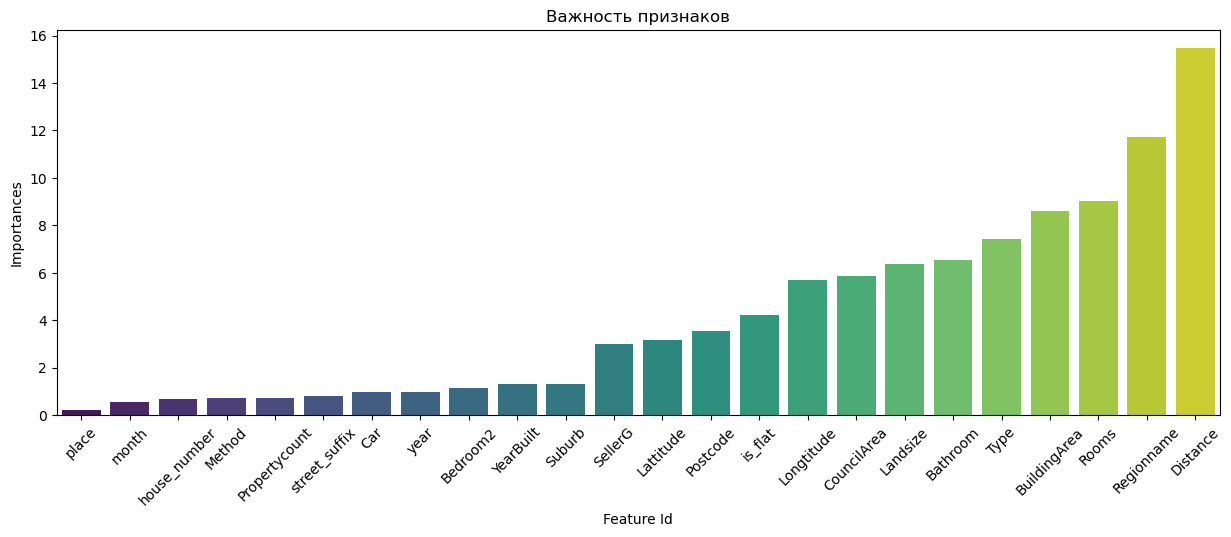

In [171]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=45)
plt.title("Важность признаков")
feature_importance_df = model.get_feature_importance(prettified=True)
sns.barplot(feature_importance_df, x="Feature Id", y="Importances", palette="viridis", order=feature_importance_df["Feature Id"][::-1]);

# Анализ модели с Shap

In [172]:
import shap
shap.initjs()

In [173]:
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_test)

**Вклад каждого признака в каждый объект датасета:**

In [174]:
pd.DataFrame(shap_values.values, columns=X_test.columns).head()

,Suburb,Rooms,Type,Method,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,is_flat,house_number,place,street_suffix,month,year
0,-48217.686114,70017.227777,27935.428527,-45744.627667,1912.996582,-27855.885454,-64965.635255,25879.405838,-36217.889520,-14079.223552,-29388.075176,48245.268952,5043.115840,6598.583515,-28572.611980,-47006.905163,-100944.977200,-2432.902190,34796.606075,6209.167780,-2366.807845,2797.268392,-2220.435242,28551.817961
1,-10252.545907,-171120.335028,-222313.024002,17879.224487,-24978.832955,7547.788373,-80344.608649,-25320.469356,-39896.026581,-28968.389576,115640.088812,-132250.496325,-20601.936868,-7974.836875,29934.672741,-23535.228775,30585.794232,-177.176599,-88264.100652,3894.713554,-9539.442025,3590.116427,-699.601940,23296.403782
2,73453.240630,90458.486888,96619.682227,7379.828323,-60067.934839,1296.278345,126564.744755,58288.924310,137135.667039,11599.161551,376606.135619,289807.571345,-46780.066344,10079.647975,-23550.119366,-56109.522987,70482.222856,83202.332078,40274.465390,11068.782705,-7470.752139,-12490.325447,-13267.262678,-57906.376146
3,4884.852773,4388.072978,-37869.737914,14333.502996,-8947.383594,-147500.742051,-69169.109022,631.063161,19775.554921,4607.359323,-115869.705482,-16585.253412,-19645.698491,38186.340870,16350.441209,-69997.251276,-47740.369125,-691.873437,20332.773142,-6096.606786,6283.219217,-18543.242759,-2971.460932,25981.792762
4,-8880.042264,-189391.940787,-150064.895523,-51887.856521,-21281.172477,59053.948086,-54064.598834,-27982.333217,-52310.555777,-8096.712087,-14983.260436,-122908.950096,6076.731705,31129.993974,54153.195312,10358.513958,30345.544795,2424.023403,-96568.514693,10393.361729,-5218.069586,-1668.960288,-2371.000973,-35580.702061


**Можно посмотреть, как влияют признаки на конкретный объект:**

In [175]:
shap.plots.force(shap_values[1, :])

**Визуализация того, как каждый объект с определенным значением признака вносит вклад (SHAP value) в предсказание модели**

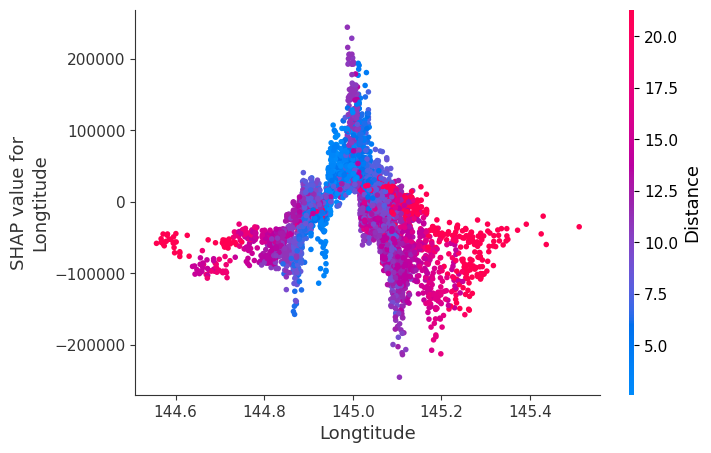

In [176]:
shap.dependence_plot("Longtitude", shap_values.values, X_test, interaction_index="Distance")

**Можно посмотреть на вклад каждого признака в зависимости от значении**

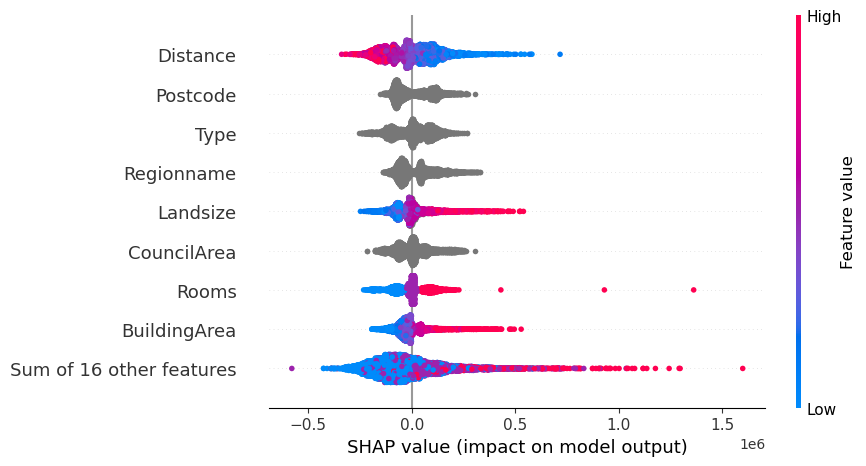

In [177]:
shap.plots.beeswarm(shap_values, max_display=9)

# Кросс-валидация с помощью функции cv

In [97]:
params = {"iterations": 300,
          "depth": 8,
          "random_strength": 2.5,
          "l2_leaf_reg": 12,
          "bagging_temperature": 0.5,
          "loss_function": "RMSE",
          "eval_metric": "MAPE",
          "verbose": False, 
          "task_type": "GPU", 
          "learning_rate": 0.2, 
          "early_stopping_rounds": 100}

In [98]:
cross_val_score = cv(pool=train_pool, 
                     params=params, 
                     fold_count=5, 
                     partition_random_seed=0,
                     shuffle=True,
                     #stratified=True,
                     plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]
bestTest = 0.1587916606
bestIteration = 222
Training on fold [1/5]
bestTest = 0.1554046804
bestIteration = 174
Training on fold [2/5]
bestTest = 0.1505887537
bestIteration = 295
Training on fold [3/5]
bestTest = 0.1510108061
bestIteration = 299
Training on fold [4/5]
bestTest = 0.1485297596
bestIteration = 299


In [101]:
cross_val_score.tail()

,iterations,test-MAPE-mean,test-MAPE-std,train-MAPE-mean,train-MAPE-std,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
295,295,0.153024,0.004208,0.139635,0.006689,268938.976511,8161.248887,230496.438095,12997.578997
296,296,0.153022,0.004216,0.139603,0.006689,268857.350941,8263.424819,230394.217808,13009.462125
297,297,0.152989,0.004238,0.139559,0.006715,268773.524781,8299.162240,230270.693451,13075.260566
298,298,0.152982,0.004248,0.139545,0.006720,268776.984992,8306.152031,230254.912454,13085.143378
299,299,0.152973,0.004257,0.139510,0.006764,268758.313767,8297.841357,230152.873308,13236.467973


# Подбор параметров с помощью Randomized Search

In [105]:
search_params = {"random_strength": np.arange(0, 6, 0.01),
                 "l2_leaf_reg": np.arange(0.1, 25, 0.1),
                 "bagging_temperature": np.arange(0, 15, 0.05)}

In [108]:
model = CatBoostRegressor(iterations=500, 
                          learning_rate=0.4, 
                          depth=8, 
                          random_state=17, 
                          task_type="GPU",  
                          eval_metric="MAPE", 
                          #logging_level="Silent",
                          verbose=False,
                          early_stopping_rounds=75)

randomized_search_result = model.randomized_search(search_params, train_pool, cv=5, plot=True, n_iter=5)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.1494314657
bestIteration = 417
0:	loss: 0.1494315	best: 0.1494315 (0)	total: 30.6s	remaining: 2m 2s
bestTest = 0.1529293727
bestIteration = 257
1:	loss: 0.1529294	best: 0.1494315 (0)	total: 50.9s	remaining: 1m 16s
bestTest = 0.1584791839
bestIteration = 444
2:	loss: 0.1584792	best: 0.1494315 (0)	total: 1m 22s	remaining: 55.2s
bestTest = 0.1648605681
bestIteration = 226
3:	loss: 0.1648606	best: 0.1494315 (0)	total: 1m 42s	remaining: 25.5s
bestTest = 0.173792674
bestIteration = 186
4:	loss: 0.1737927	best: 0.1494315 (0)	total: 1m 58s	remaining: 0us
Estimating final quality...
Training on fold [0/5]
bestTest = 0.1571880623
bestIteration = 462
Training on fold [1/5]
bestTest = 0.1504162092
bestIteration = 336
Training on fold [2/5]
bestTest = 0.1512017083
bestIteration = 406
Training on fold [3/5]
bestTest = 0.1520637618
bestIteration = 316
Training on fold [4/5]
bestTest = 0.1518092894
bestIteration = 268


In [110]:
randomized_search_result["params"]

{'bagging_temperature': 1.25, 'random_strength': 1.44, 'l2_leaf_reg': 21.4}

# Подбор параметров с помощью Hyperopt

In [119]:
from hyperopt import fmin, tpe, STATUS_OK, Trials, hp

In [112]:
default_params = {"depth": 8,
                  "iterations": 400, 
                  "learning_rate": 0.2,
                  "loss_function": "RMSE",
                  "eval_metric": "MAPE", 
                  "task_type": "GPU", 
                  "logging_level": "Silent",
                  "early_stopping_rounds": 100}

hp_params = {"l2_leaf_reg":         hp.uniform("l2_leaf_reg", 0, 20),
             "random_strength":     hp.uniform("random_strength", 0, 10),
             "bagging_temperature": hp.uniform("bagging_temperature", 0, 5)}

In [115]:
class HyperOpt:
    def __init__(self, train_pool, default_params):
        self.train_pool = train_pool
        self.default_params = default_params

    def fit(self, space, trials, algo, max_evals):
        fn = getattr(self, "train_model")
        result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)

        return result, trials
    
    def train_model(self, params):
        params = self.default_params | params
        loss = cv(self.train_pool, params, fold_count=5)["test-MAPE-mean"].min()
        return {'loss': loss, 'status': STATUS_OK}

In [116]:
hyperopt_obj = HyperOpt(train_pool, default_params)
result, trials = hyperopt_obj.fit(hp_params, Trials(), tpe.suggest, 5)

100%|████████████████████████████████████████████████| 5/5 [10:29<00:00, 125.81s/trial, best loss: 0.15089013382072486]


In [117]:
result

{'bagging_temperature': 1.8746303978132501,
 'l2_leaf_reg': 18.01504923474559,
 'random_strength': 1.5478968747772992}

In [252]:
train_pool.shape

(12309, 24)

# Feature Selection

**Можно рекурсивно удалять признаки, которые вносят низкий вклад в предсказание модели. [Cсылка](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features) на документацию**

Параметр `algorithm` принимает следующие значения:

- `RecursiveByPredictionValuesChange` - расчитывается на основе того, насколько сильно в среднем меняются предсказанные значения при изменений значении признака. Наиболее быстрый, но менее точный, чем другие методы.<br>
<br>
- `RecursiveByLossFunctionChange` - расчитывается на идее того, что для каждого признака этот метод представляет собой разницу между значением функции потерь для модели с этим признаком и без него. Так как такой метод был бы вычислительно затратным, то в catboost используется приближение для каждой модели путем удаления признака из всех деревьев в ансамбле. Более точный, чем предыдущий метод.<br>
<br>
- `RecursiveByShapValues` - метод похож на предыдущий, поскольку также рассчитывает изменение функции потерь после удаления признака. Но разница в том, что изменение функции потерь пересчитываются после каждого удаления признака. Самый точный.<br>

In [276]:
model = CatBoostRegressor(iterations=500, random_seed=0)

summary = model.select_features(
    train_pool,                #тренировочная выборка
    eval_set=test_pool,        #выборка для выбора лучшей итерации и обнаружения переобучения
    features_for_select='0-23',#признаки (индексы или названия), которые участвуют в выборе. Пример: [0, 5, 6, '10-15', 'Rooms']
    num_features_to_select=17, #количество признаков для выбора (которые не удаляются)
    steps=5,                   #сколько раз можно обучить модель. Больше шагов - более точный выбор
    algorithm="RecursiveByShapValues",
    shap_calc_type="Exact",    #Тип вычисления значений SHAP, работает только для RecursiveByLossFunctionChange и RecursiveByShapValues
                               #Approximate, Regular, Exact - отсортирован по точности, где Exact - самый точный
    train_final_model=False,    #Если True, то после выбора признаков будет обучена модель с выбранными признаками
    logging_level='Silent',
    plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [277]:
X_train.columns[summary['eliminated_features']] #удаленные признаки

Index(['month', 'place', 'Suburb', 'house_number', 'Propertycount',
       'street_suffix', 'Bedroom2'],
      dtype='object')

In [278]:
X_train.columns[summary['selected_features']] #выбранные признаки

Index(['Rooms', 'Type', 'Method', 'SellerG', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 'is_flat',
       'year'],
      dtype='object')

In [281]:
pd.DataFrame({"feature": ["with_all_features"]+[f+"_deleted" for f in summary['eliminated_features_names']],
              "loss": summary["loss_graph"]["loss_values"]})

,feature,loss
0,with_all_features,259006.673051
1,month_deleted,258816.281851
2,place_deleted,259761.319080
3,Suburb_deleted,260446.446307
4,house_number_deleted,256800.839683
5,Propertycount_deleted,257523.715463
6,street_suffix_deleted,258384.822824
7,Bedroom2_deleted,260290.248109


# Object Selection

**Поддерживаемые функции потерь: `Logloss`, `CrossEntropy`, `RMSE`, `MAE`, `Quantile`, `Expectile`, `LogLinQuantile`, `MAPE`, `Poisson`**

**Позволяет оценить влияние каждого элемента обучающей выборки на значение целевой метрики (eval_metric). То есть, с помощью этого метода можно найти и избавиться от выбросов, шума и прочего мусора в тренировочном датасете.**

In [344]:
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          eval_metric="MAPE", 
                          random_seed=17, 
                          early_stopping_rounds=100, 
                          verbose=False)

model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [345]:
mean_absolute_percentage_error(y_test, model.predict(X_test))

0.14501198413949307

In [346]:
#метод возвращает отсортированные списки индексов и скоров
idxs, scores = model.get_object_importance(
    test_pool,   #данные для расчета важности объектов
    train_pool,  #набор данных, используемый для обучения
    
    top_size=-1, #количество наиболее важных объектов из трейн выборки. 
                 #количество возвращаемых объектов ограничено этим числом (-1 без ограничений)
    
    type='Average', #метод расчета важности объектов: Average или PerObject (этот дольше работает)
    
    update_method='AllPoints', #метод точности алгоритма. Значения: SinglePoint (самый быстрый и наименее точный), TopKLeaves,
                               #AllPoints - самый медленный и точный метод
    
    importance_values_sign='All' #Значения: Positive, Negative, All
)

In [347]:
#удалим топ 100 плохих объектов
train_pool = Pool(
    X_train.reset_index(drop=True).drop(idxs[:100]),
    y_train.reset_index(drop=True).drop(idxs[:100]),
    cat_features=cat_features,
)

In [348]:
model = CatBoostRegressor(iterations=2000,
                          learning_rate=0.1,
                          eval_metric="MAPE", 
                          random_seed=17, 
                          early_stopping_rounds=100, 
                          verbose=False)

model.fit(train_pool, eval_set=test_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

**Уменьшение MAPE на ~0,00259**

In [349]:
mean_absolute_percentage_error(y_test, model.predict(X_test))

0.14241969280951625

# [Классификация](https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb)